In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from utils import MRIDataset

# Set Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"✓ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using NVIDIA GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU (slower training)")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

✓ Using Apple Silicon GPU (MPS)


In [2]:
# Configuration
DATA_DIR = '../../Data/task4/' 
CLASSES = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
LABEL_MAP = {name: idx for idx, name in enumerate(CLASSES)}

--- Dataset Structure Analysis ---
Total Images: 86437
Unique Patients: 347
Images per Patient (Avg): 249.1

--- Unique Patients per Class ---
class_name
Mild Dementia          21
Moderate Dementia       2
Non Demented          266
Very mild Dementia     58
Name: patient_id, dtype: int64

Visualizing Patient: OAS1_0349 (Class: Non Demented)
This patient has 244 images across 4 MPR scans.


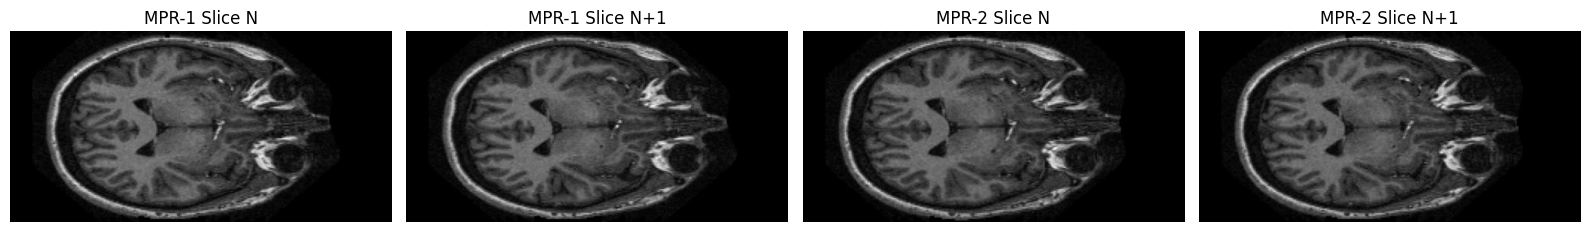


CONCLUSION: Neighboring slices and repeated scans (MPR) are nearly identical.
If we split randomly, the model will see 'MPR-1 Slice N' in Train and 'MPR-2 Slice N' in Test.
This is DATA LEAKAGE. The model memorizes the patient's anatomy instead of disease features.


In [3]:
# 1. Load Data & Parse Filenames
data = []
for label_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, label_name)
    if not os.path.exists(class_dir):
        continue
    
    for file in os.listdir(class_dir):
        if file.endswith('.jpg'):
            # Filename: OAS1_0028_MR1_mpr-1_100.jpg
            parts = file.split('_')
            patient_id = f"{parts[0]}_{parts[1]}"  # OAS1_0028
            scan_type = parts[3]  # mpr-1, mpr-2...
            
            data.append({
                'path': os.path.join(class_dir, file),
                'label': LABEL_MAP[label_name],
                'class_name': label_name,
                'patient_id': patient_id,
                'scan_type': scan_type
            })

df = pd.DataFrame(data)

# 2. Leakage Analysis Stats
print("--- Dataset Structure Analysis ---")
print(f"Total Images: {len(df)}")
print(f"Unique Patients: {df['patient_id'].nunique()}")
print(f"Images per Patient (Avg): {len(df) / df['patient_id'].nunique():.1f}")

# Show patients per class
patient_counts = df.groupby('class_name')['patient_id'].nunique()
print("\n--- Unique Patients per Class ---")
print(patient_counts)

# 3. Visualize Leakage Potential
# Show multiple slices and scans for ONE patient to show how similar they are
example_patient = df['patient_id'].unique()[0]
patient_data = df[df['patient_id'] == example_patient].sort_values('path')

print(f"\nVisualizing Patient: {example_patient} (Class: {patient_data.iloc[0]['class_name']})")
print(f"This patient has {len(patient_data)} images across {patient_data['scan_type'].nunique()} MPR scans.")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
# Pick 2 slices from mpr-1 and 2 slices from mpr-2
samples = [
    patient_data[patient_data['scan_type'] == 'mpr-1'].iloc[10], # Slice ~110
    patient_data[patient_data['scan_type'] == 'mpr-1'].iloc[11], # Slice ~111 (Neighbor)
    patient_data[patient_data['scan_type'] == 'mpr-2'].iloc[10], # Same slice, diff scan
    patient_data[patient_data['scan_type'] == 'mpr-2'].iloc[11]
]

titles = ["MPR-1 Slice N", "MPR-1 Slice N+1", "MPR-2 Slice N", "MPR-2 Slice N+1"]

for ax, sample, title in zip(axes, samples, titles):
    img = Image.open(sample['path'])
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\nCONCLUSION: Neighboring slices and repeated scans (MPR) are nearly identical.")
print("If we split randomly, the model will see 'MPR-1 Slice N' in Train and 'MPR-2 Slice N' in Test.")
print("This is DATA LEAKAGE. The model memorizes the patient's anatomy instead of disease features.")

In [4]:
# --- 1. Subject-Level Split ---
# We use StratifiedGroupKFold to split while keeping patients grouped AND maintaining class balance
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

# Create a 'fold' column
df['fold'] = -1
# X=paths (ignored), y=labels, groups=patient_id
for fold_i, (train_idx, val_idx) in enumerate(sgkf.split(df, df['label'], groups=df['patient_id'])):
    df.loc[val_idx, 'fold'] = fold_i

# Use Fold 0 for Test (10%), Fold 1 for Val (10%), Folds 2-9 for Train (80%)
test_df = df[df['fold'] == 0].reset_index(drop=True)
val_df = df[df['fold'] == 1].reset_index(drop=True)
train_df = df[df['fold'] >= 2].reset_index(drop=True)

print(f"Train Patients: {train_df['patient_id'].nunique()} ({len(train_df)} images)")
print(f"Val Patients:   {val_df['patient_id'].nunique()} ({len(val_df)} images)")
print(f"Test Patients:  {test_df['patient_id'].nunique()} ({len(test_df)} images)")


# Check patients per class in each dataset
print("\n--- Patient Distribution by Class ---")
for dataset_name, dataset_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"\n{dataset_name} Set:")
    class_patient_counts = dataset_df.groupby('class_name')['patient_id'].nunique()
    for class_name, patient_count in class_patient_counts.items():
        print(f"  {class_name}: {patient_count} patients")

# Verify no overlap
assert set(train_df['patient_id']) & set(val_df['patient_id']) == set()
assert set(train_df['patient_id']) & set(test_df['patient_id']) == set()
print("Leakage Check: PASSED ✅")

Train Patients: 277 (69052 images)
Val Patients:   35 (8662 images)
Test Patients:  35 (8723 images)

--- Patient Distribution by Class ---

Train Set:
  Mild Dementia: 17 patients
  Moderate Dementia: 2 patients
  Non Demented: 212 patients
  Very mild Dementia: 46 patients

Val Set:
  Mild Dementia: 2 patients
  Non Demented: 27 patients
  Very mild Dementia: 6 patients

Test Set:
  Mild Dementia: 2 patients
  Non Demented: 27 patients
  Very mild Dementia: 6 patients
Leakage Check: PASSED ✅


In [5]:
# ImageNet Stats for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), 
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [6]:
# Calculate weights for the sampler
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_df['label']]
sample_weights = torch.DoubleTensor(sample_weights)

# This sampler will feed the DataLoader balanced batches
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Datasets
train_ds = MRIDataset(train_df, transform=train_transforms)
val_ds = MRIDataset(val_df, transform=val_test_transforms)
test_ds = MRIDataset(test_df, transform=val_test_transforms)

# DataLoaders
BATCH_SIZE = 32
# Note: shuffle=False when using sampler
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True) 
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
def get_model(num_classes):
    # Load Pretrained ResNet18
    model = models.densenet121(pretrained=True)
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    # DenseNet121 has 4 blocks. unfreeze the 4th.
    for param in model.features.denseblock4.parameters():
        param.requires_grad = True
    
    # Unfreeze the final normalization layer 
    for param in model.features.norm5.parameters():
        param.requires_grad = True
    
    # Replace final layer
    num_ftrs = model.classifier.in_features
    # Dropout to fight overfitting
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),  # Drop 50% of connections
        nn.Linear(num_ftrs, num_classes)
    )
    
    return model

In [8]:
model = get_model(len(CLASSES))
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3) #  weight_decay for regularization and Lower LR for fine-tuning

# Learning Rate Scheduler
# doesn't improve for 2 epochs, cut LR by 10%
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2
)

/Users/ldr0/Documents/UPM/Complex Data/FinalProject/scripts/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ldr0/Documents/UPM/Complex Data/FinalProject/scripts/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_epochs = 20
patience = 5
best_val_loss = float('inf')
counter = 0

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct / total
    
    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = val_correct / val_total
    
    # Step the scheduler
    scheduler.step(epoch_val_loss)
    
    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # --- EARLY STOPPING ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'reg_densenet_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model, not the one overfitted when counter >= patience
model.load_state_dict(torch.load('reg_densenet_model.pth'))

/Users/ldr0/Documents/UPM/Complex Data/FinalProject/scripts/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20] Train Loss: 1.0319 Acc: 0.6027 | Val Loss: 0.8599 Acc: 0.7317
Epoch [2/20] Train Loss: 0.7538 Acc: 0.7882 | Val Loss: 0.8691 Acc: 0.7286
Epoch [3/20] Train Loss: 0.6610 Acc: 0.8482 | Val Loss: 0.8417 Acc: 0.7486
Epoch [4/20] Train Loss: 0.6095 Acc: 0.8794 | Val Loss: 0.8300 Acc: 0.7525
Epoch [5/20] Train Loss: 0.5769 Acc: 0.8991 | Val Loss: 0.8214 Acc: 0.7580
Epoch [6/20] Train Loss: 0.5500 Acc: 0.9130 | Val Loss: 0.8457 Acc: 0.7637
Epoch [7/20] Train Loss: 0.5312 Acc: 0.9244 | Val Loss: 0.8514 Acc: 0.7632
Epoch [8/20] Train Loss: 0.5158 Acc: 0.9329 | Val Loss: 0.8452 Acc: 0.7553
Epoch [9/20] Train Loss: 0.5056 Acc: 0.9397 | Val Loss: 0.8372 Acc: 0.7666
Epoch [10/20] Train Loss: 0.5044 Acc: 0.9397 | Val Loss: 0.8356 Acc: 0.7658
Early stopping triggered!


<All keys matched successfully>

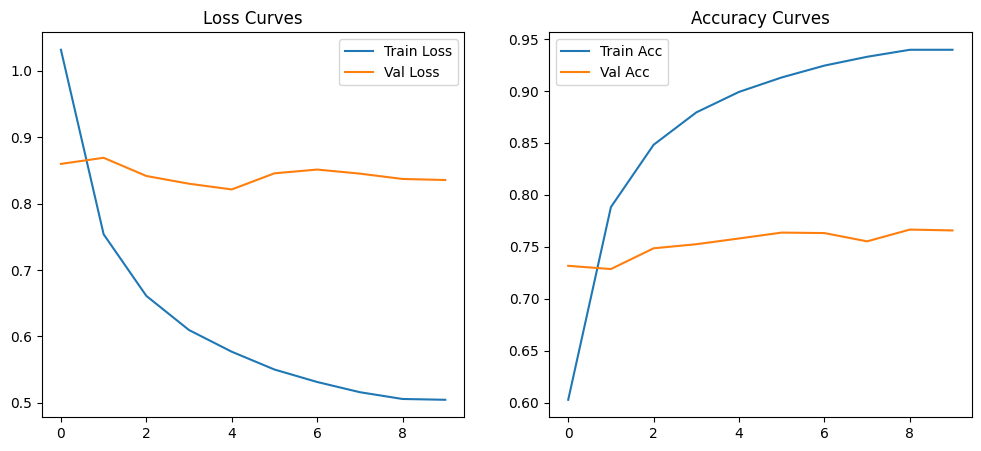

Classes present in test set: ['Non Demented', 'Very mild Dementia', 'Mild Dementia']
Number of test classes: 3
                    precision    recall  f1-score   support

      Non Demented       0.91      0.86      0.88      6832
Very mild Dementia       0.44      0.49      0.47      1403
     Mild Dementia       0.24      0.33      0.28       488

         micro avg       0.77      0.77      0.77      8723
         macro avg       0.53      0.56      0.54      8723
      weighted avg       0.79      0.77      0.78      8723



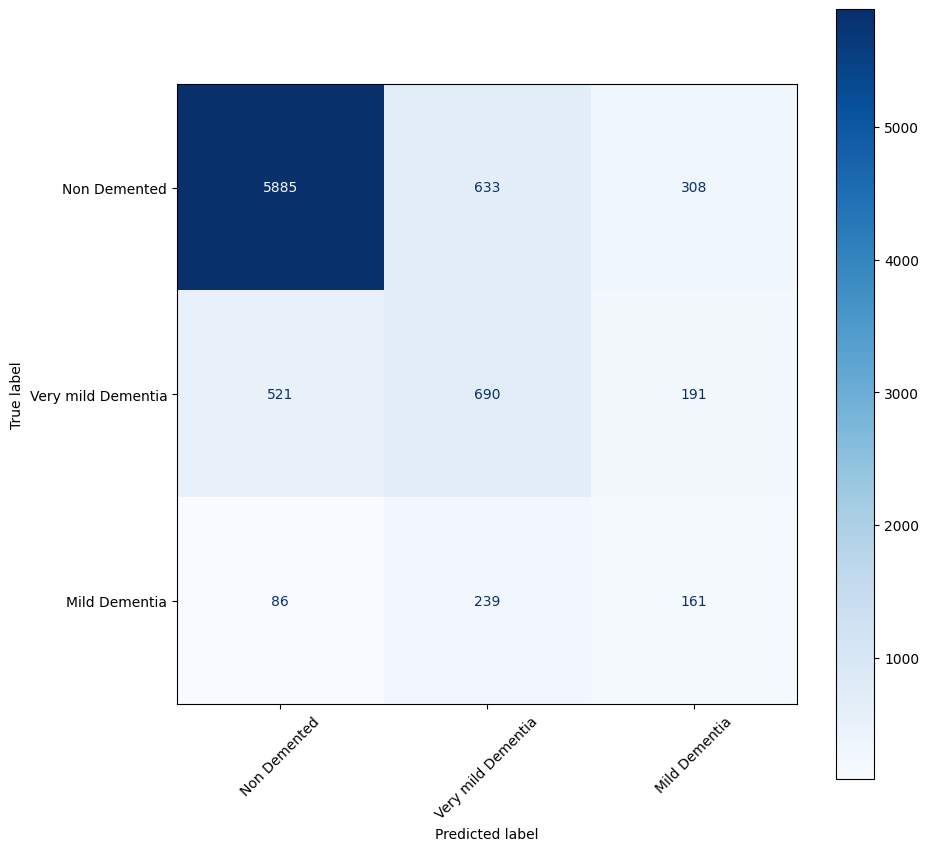

In [10]:
# Visualizing Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get unique classes present in test set
unique_test_labels = sorted(list(set(all_labels)))
test_class_names = [CLASSES[i] for i in unique_test_labels]

print(f"Classes present in test set: {test_class_names}")
print(f"Number of test classes: {len(unique_test_labels)}")

# Confusion Matrix & Report
print(classification_report(all_labels, all_preds, 
                          labels=unique_test_labels,
                          target_names=test_class_names))

cm = confusion_matrix(all_labels, all_preds, labels=unique_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45)
plt.show()

Loaded model weights from reg_densenet_model.pth
Running inference on test set...


/Users/ldr0/Documents/UPM/Complex Data/FinalProject/scripts/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Patient-Level Performance (Total Patients: 35) ---
                    precision    recall  f1-score   support

      Non Demented       0.88      0.85      0.87        27
Very mild Dementia       0.29      0.33      0.31         6
     Mild Dementia       0.00      0.00      0.00         2

          accuracy                           0.71        35
         macro avg       0.39      0.40      0.39        35
      weighted avg       0.73      0.71      0.72        35



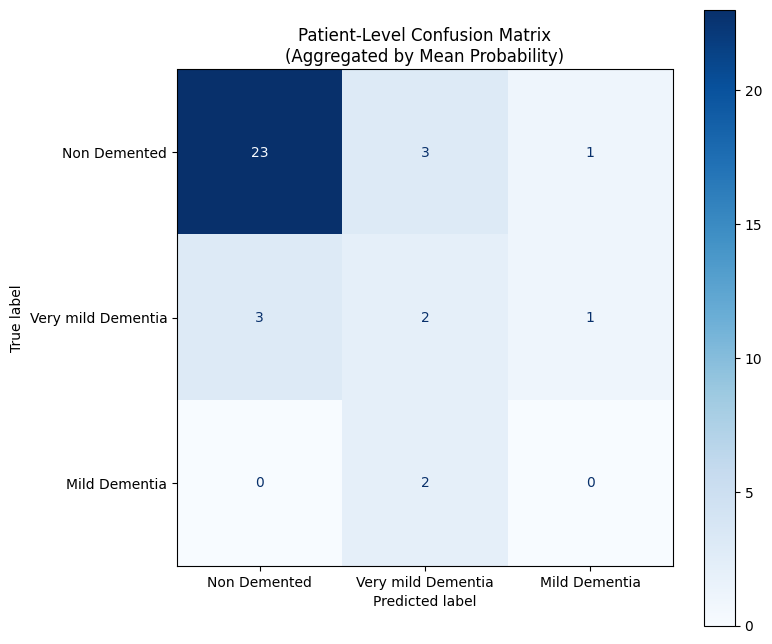


[Analysis] The model misclassified 10 patients.
   patient_id          class_name  final_pred  prob_Non Demented  \
10  OAS1_0106        Non Demented           1           0.449804   
11  OAS1_0123  Very mild Dementia           0           0.776038   
13  OAS1_0137       Mild Dementia           1           0.136371   
14  OAS1_0142  Very mild Dementia           0           0.485540   
18  OAS1_0210  Very mild Dementia           2           0.265550   

    prob_Very mild Dementia  prob_Mild Dementia  prob_Moderate Dementia  
10                 0.470370            0.060431                0.019394  
11                 0.102635            0.096033                0.025294  
13                 0.454639            0.339534                0.069456  
14                 0.439007            0.035313                0.040140  
18                 0.321366            0.380092                0.032992  


In [9]:
# --- PATIENT-LEVEL EVALUATION (Industry Standard) ---

# Load the model weights from reg_densenet_model.pth
model.load_state_dict(torch.load("reg_densenet_model.pth", map_location=device))
print("Loaded model weights from reg_densenet_model.pth")

model.eval()
slice_probs = []
slice_labels = []

print("Running inference on test set...")

# 1. Slice-Level Inference
# We collect probabilities (Softmax) instead of just hard predictions
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        # Get raw logits from model
        logits = model(images)
        
        # Convert to probabilities [0.0 - 1.0] using Softmax
        # dim=1 ensures each row sums to 1
        probs = torch.nn.functional.softmax(logits, dim=1)
        
        # Store results
        slice_probs.append(probs.cpu().numpy())
        slice_labels.extend(labels.numpy())

# Concatenate all batches into one large array
all_slice_probs = np.concatenate(slice_probs)

# 2. Map Predictions back to Patient IDs
# We make a copy of test_df. Since shuffle=False in test_loader, the order matches perfectly.
patient_results = test_df.copy()

# Add probability columns for each class to the dataframe
for i, class_name in enumerate(CLASSES):
    patient_results[f'prob_{class_name}'] = all_slice_probs[:, i]

# 3. Aggregation: Group by Patient ID
# We calculate the MEAN probability for each class across all slices of a patient
prob_cols = [f'prob_{c}' for c in CLASSES]
patient_agg = patient_results.groupby('patient_id').agg({
    **{col: 'mean' for col in prob_cols},  # Average the probabilities
    'label': 'first',                      # Keep the true label (same for all slices)
    'class_name': 'first'                  # Keep the true class name
}).reset_index()

# 4. Final Decision
# The predicted class is the one with the highest AVERAGE probability
patient_agg['final_pred'] = np.argmax(patient_agg[prob_cols].values, axis=1)

# --- RESULTS VISUALIZATION ---

# Extract ground truth and predictions at patient level
y_true_patient = patient_agg['label'].values
y_pred_patient = patient_agg['final_pred'].values

# Get unique classes present in the test set (in case some are missing)
unique_labels = sorted(list(set(y_true_patient)))
target_names = [CLASSES[i] for i in unique_labels]

print(f"\n--- Patient-Level Performance (Total Patients: {len(patient_agg)}) ---")
print(classification_report(y_true_patient, y_pred_patient, 
                            labels=unique_labels, 
                            target_names=target_names))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_patient, y_pred_patient, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' for integer formatting
plt.title(f"Patient-Level Confusion Matrix\n(Aggregated by Mean Probability)")
plt.show()

# Optional: Inspect mistakes
mistakes = patient_agg[patient_agg['label'] != patient_agg['final_pred']]
if not mistakes.empty:
    print(f"\n[Analysis] The model misclassified {len(mistakes)} patients.")
    print(mistakes[['patient_id', 'class_name', 'final_pred'] + prob_cols].head())